# Digital Library of India Telugu Deduplication


Author: Arjuna Rao Chavala,(arjunaraoc@gmail.com)

Date of inital draft: 2018-11-26



## Abstract

This study explores the work done to identify duplicate items of Telugu collection of  Digital Library of India. After extensive updates to metadata and further analysis, it is observed that more than 20% of items are duplicates, which consume storage and also require that much more effort towards any task improving the collection. Original file size of the item is identified as the key parameter to identify duplicates. The study is presented as Jupyter notebook with code in Python 3 so that the research becomes reproducible and can be applied to other language collection on Digital Library of India. 




## Introduction

[Digital Library of India](https://web.archive.org/web/20081012083329/https://www.cmu.edu/news/archive/2007/November/nov27_ulib.shtml) Telugu items as uploaded onto Internet Archive by Public resource comprised of 22946 items as of May 2018.  The metadata was written in English, with no easy way to decipher their actual Telugu information correctly. IT3 coding, supposed to have been used was mostly full of errors. [The initiative to transform the metadata to Telugu](https://goo.gl/1k1g7j) was started in 2013 by Arjuna Rao, a Wikipedia volunteer for a set of 2265 entries. [Another initiative to transform metadata and also prepare a paragraph summaries and subject information](https://goo.gl/k4M8wB) was led by Pavan Santhosh, as a funded project of Wikimedia Foundation was started in  June 2014 and completed in Sep 2015, resulting in about 6000 entries.

[DLI project server in India was taken down in late 2017](https://web.archive.org/web/20181127050654/https:/twitter.com/cmtripathi/status/895199439324823552) as some copyright issues were needed to be looked into. Meanwhile during early 2017, Public Resource [uploaded](https://web.archive.org/web/20181127052657/https://twitter.com/i/web/status/875184552456577024) the data available from DLI to internet archive.

Arjuna always wished to see the DLI Telugu books metadata in Telugu Script on the servers and set out to  analyse the output of Pavan's project in Feb 2018. He was able to get the data into a table form and requested Carl's help for updating the info on archive.org. Carl readily agreed and helped with the request.   He also contacted DLI authorities for information on IT3 and did not receive any help. He developed a python software package called [indic-IT3-converter](https://github.com/arjunaraoc/indic-it3-converter) to convert to Telugu based on the available IT3 code knowledge and  applied it on the data. The converted data was found to be not useful as IT3 coded data was full of errors.  Arjuna initiatied a crowd sourcing initiative through Wikipedia and Wikisource projects  to convert the metadata of remaining Telugu items. When he started, he had to browse each item and update the data on a spreadsheet. It was time consuming taking about two minutes for each time and was estimated to require 568 person hours. After some time, it felt like it will take an year and half as not much involvment happened with the crowd.

Meanwhile, Chaduvari, a Wikipedian said that he could help speed it up, through approximate conversions based on heuristics about the English transliteration and submitted data for around 3000 items. While reviewing, Arjuna found that around half of them were already converted by Pavan. For some of the remaining items, he found IT3-indic converter has done a good job yielding proper Telugu text. He explored and found that such items were largely from the work done at IIIT-H, a center which had academicians working on the project  and also hosted a regional mega scanning center. He found few bugs and fixed them, yielding better Telugu converted data. The data conversion gained some speed with this development, as around 6000 items were from this center. Reviewing the converted data by browsing the individual items was continued. He proceeded to do manually gather metadata for the remaining items and few volunteers supported to a limited extent.

He encountered all kinds of errors, incorrect language tag, incorrect facing page, **large number of duplicates**, incorrect scans during the process. He also located other items which were from Telugu, but were incorrectly flagged and added them to Telugu, while correct the items which were incorrectly flagged  Telugu. Title, Author metadata were corrected initially. Later the published date also was reviewed and inaccuracies were rectified.  As of 26 Nov 2018, Telugu items number 22898. The following sections explore the workdone to identify the duplicates, so that they could be removed, to make the collection better and also help reduce the future efforts to further improve the metadata.

### Get the metadata from archive.


In [1]:
#some preliminaries Python modules used by the code in the notebook
import pandas as pd
import numpy as np
import csv
from IPython.display import Image


In [2]:
#code for downloading catalog. commented as the live collection could change the output file is provided
#gets archive item fields and DLI description subfields
def getCollection2(resfile,numitems):
    try:
        fo=open(resfile,"w")
        error_log = open('arxerrlog.txt', 'w+')
        url = "https://archive.org/services/search/v1/scrape?"
        basic_params={ 'q':'(collection%3Adigitallibraryindia+AND+(language%3Atel++OR+language%3ATelugu))',
                       'fields':'identifier,title,creator,date,description'}
        params=basic_params.copy()
        numline = 0
        fo.write( "id"+"\t"+"title"+"\t"+"creator"+"\t"+"pubd"+"\t"+"pages"+"\t"+"bc"+"\n")
        while True:
            try:

                params_str= "&".join("%s=%s" % (k, v) for k, v in params.items())
                print (params_str)
                resp = requests.get(url+params_str, headers={})
            except requests.exceptions.RequestException as e:  # This is the correct syntax
                error_log.write('Could not get search result' + url + params+' because of error: %s\n' % e)
                print ("There was an error; writing to log.")
                sys.exit(1)
            else:
                data= resp.json()
                #write results
                iadict=data["items"]
                for i in iadict:
                    iaid=i['identifier']

                    iatitle=""
                    if 'title' in i:
                        iatitle=i['title']
                    iacreator=""
                    if 'creator' in i:
                        iacreator= i['creator']
                    iadate=""
                    if 'date' in i:
                        iadate= i['date']
                    iadesc=""
                    iadesc_totpages=""
                    iadesc_barcode=""
                    if 'description' in i:
                        iadesc=i['description']
                        
                        totpagessearchstr = "dc.description.totalpages" + ": " + "([0-9]+)"
                        m = re.search(totpagessearchstr,iadesc)
                        if m:
                            iadesc_totpages = m.group(1)
                        
                        # barcode search
                        bcsearchstr = "dc.identifier.barcode" + ": " + "([0-9]+)"
                        m = re.search(bcsearchstr,iadesc)
                        if m:
                            iadesc_barcode = m.group(1)


                    fo.writelines("%s\t%s\t%s\t%s\t%s\t%s\n" % (iaid,iatitle,iacreator,iadate,
                                                                    iadesc_totpages,iadesc_barcode))
                    numline += 1
                    if (numitems != 0) and (numline > numitems):
                        break
                if (numitems != 0) and (numline > numitems):
                    break
                cursor = data.get('cursor', None)
                print(cursor)
                if cursor is None:
                    break
                else:
                    params = basic_params.copy()
                    params['cursor'] = cursor
        fo.close()
    except IOError:
        print ("Error: can\'t find file or read data")
#getCollection2("data/arxtelcat.tsv",0)

#dlicat=pd.read_csv("data/arxtelcat.tsv",index_col=None,converters={i: str for i in range(1,100)})
#dlicat.to_csv("data/arxtelfin.csv")

## Final dataset

The data is organised as identifier(archive.org, title, creator, publication date(pubd), pages and DLI barcode(bc)
Barcode contains information as follows( Number of digits given after the field )
<center no:1 or 2>,<Vendor number:2><Scanning location:3><source library:3><item number:7>


If you look at the samples(below), even bc was not captured properly by DLI as evidenced by all 9s for some of the fields.

In [3]:
cat=pd.read_csv("data/arxtelfin.csv",index_col=0,converters={i: str for i in range(1,100)})
cat.head()

,id,title,creator,pubd,pages,bc
0,in.ernet.dli.2015.108849,"ఇంగ్లీషు తెలుగు నిఘంటువు (ఇంగ్లీషు సామెతలు, వా...",చార్లెస్ ఫిలిప్ బ్రౌన్(సం.),1852-01-01T00:00:00Z,1394,2020050089595
1,in.ernet.dli.2015.287796,పళ్లు,"రంజీత్ సింగ్, ఆర్.ఎల్.ఎన్.శాస్త్రి(అను.)",1974-01-01T00:00:00Z,268,99999990175502
2,in.ernet.dli.2015.287798,బడాపానీ,"లీలా మజుందార్(మూలం), వి.పతంజలి(అను.)",1973-01-01T00:00:00Z,66,99999990175628
3,in.ernet.dli.2015.287799,మన వార్తాపత్రికల కథ,"చంచల్ సర్కార్, కె.గోదావరి శర్మ(అను.)",1996-01-01T00:00:00Z,66,99999990175630
4,in.ernet.dli.2015.287800,లెట్స్ డూ ఏ ప్లే(Lets Do A Play),ఉమా ఆనంద్,1972-01-01T00:00:00Z,64,99999990175631


### Summary info

In [4]:
cat.describe(include='all')

,id,title,creator,pubd,pages,bc
count,22828,22828,22828,22828,22828,22828
unique,22828,15003,9312,1013,951,22828
top,in.ernet.dli.2015.394120,సారంగధర చరిత్రము,,1955-01-01T00:00:00Z,34,02020120034189
freq,1,15,972,453,281,1


    So there are 15003 unique titles, 9312 unique creators, 1013 distinct publication dates, 951 different number of book's pages.  One title is shared by 15 items, one creator authored 972 items , one publication date is shared by 453 items, and 281 items have same number of pages.

 Uniqueness based on various parameters is given below. (output cell shows the count)

In [5]:
dfg1=cat.groupby(['title','creator'],sort=False)
dfg1.ngroups

16115

In [6]:
dfg2=cat.groupby(['title','creator','pubd'],sort=False)
dfg2.ngroups

16490

In [7]:
dfg3=cat.groupby(['title','creator','pubd','pages'],sort=False)
dfg3.ngroups

17353

In the above 'pages' information is  assumed to be derived by computer algorithm and is assumed 100% correct for the scanned item, while there could be manual errors in the others.

Let's investigate the potential duplicates 5545(22898-17353) (or 24.21% of the total collection) further.

In [8]:
csvfile = open('data/flagdupset1.csv', 'w', newline="")
writer = csv.writer(csvfile, delimiter=",")
for name, group in dfg3:
    if len(group)>1:
        duplist=group['id'].tolist()
        writer.writerow(duplist)
csvfile.close()

In [9]:
with open('data/flagdupset.csv') as fi:
    dup=fi.readlines()
dup[0:5]

['in.ernet.dli.2015.387992,in.ernet.dli.2015.392958\n',
 'in.ernet.dli.2015.371488,in.ernet.dli.2015.491319\n',
 'in.ernet.dli.2015.388747,in.ernet.dli.2015.390039,in.ernet.dli.2015.390104,in.ernet.dli.2015.393095\n',
 'in.ernet.dli.2015.388423,in.ernet.dli.2015.388530,in.ernet.dli.2015.389870,in.ernet.dli.2015.392879\n',
 'in.ernet.dli.2015.386125,in.ernet.dli.2015.492457\n']

In [10]:
len(dup)

3614

In [11]:
str = "in.ernet.dli"
length = len(str)
sum(element[index:index+length] == str for element in dup for index,char in enumerate(element))

9064

In the above, the first item for which duplicates are found is also included.
We have 3627 lines with total 9102 entries, out of which  3627 are to be retained and the rest deleted as they could be duplicates. Let's investigate them in more detail to confirm that they are duplicates. For this we look at the file size of the **original** that was uploaded onto internet archive(Size can be accessed by using the URL. For example: http://archive.org/metadata/in.ernet.dli.2015.387992/files). We flag comparison  as success, if all the ids have the same size. We flag them as failure, if there are differences in size. Size is included after each id in the output below.

In [12]:
# takes 17 hours for 9102 items not to be run in notebook, as the collection could change,output file provided.
# for duplicates csv file, get size, output duplicates,sizes,comparison status using api call for speedup
def sizeCompareForDuplicates2(inpfile,outpfile, numlines):
    import subprocess
    import json
    url = "https://archive.org/metadata/"
    try:
        fo=open(outpfile,"w")
        error_log = open('arxerrlog.txt', 'w+')
        line=1
        result = []
        resultset=set()
        fi=open(inpfile,"r")
        for row in fi.readlines():
            row=row.strip("\n")
            idlist=row.split(sep=",")
            index=0
            result.clear()
            resultset.clear()
            for id in idlist:
                params_str = "%s/files" % id
                print(params_str)
                try:
                    resp = requests.get(url + params_str, headers={})
                except requests.exceptions.RequestException as e:  # This is the correct syntax
                    error_log.write('Could not get search result' + url + params + ' because of error: %s\n' % e)
                    print("There was an error; writing to log.")
                    sys.exit(1)
                else:
                    data = resp.json()['result']

                size='0'
                for obj in data:
                    if obj['name'].find(".pdf")!= -1:
                        size=obj['size']
                        break
                if(int(size)==0):
                    print("Error, Did not find pdf file for determining size")
                    exit(-1)
                result.append(size)
                index+=1
            #compare resulting sizes
            resultset=set(result)
            if len(resultset)==1:
                 compare="Success"
            else:
                compare="Fail"
            #write resultline
            index=0;
            for id in idlist:
                fo.write(id+","+result[index]+",")
                index+=1
            fo.write(compare+"\n")
            print(line,compare)
            line += 1
            if (numlines != 0) and (line > numlines):
                break

    except IOError:
        print("Error: can\'t find file or read data")
#sizeCompareForDuplicates2("data/flagdupset.csv","data/flagdupsetresult2trans.csv",0)

In [13]:
with open('data/flagdupsetresult2trans.csv') as fi:
    dupcompare=fi.readlines()
dupcompare[0:5]


['in.ernet.dli.2015.387992,4159613,in.ernet.dli.2015.392958,4159613,Success\n',
 'in.ernet.dli.2015.371488,6515729,in.ernet.dli.2015.491319,10892033,Fail\n',
 'in.ernet.dli.2015.388747,21433518,in.ernet.dli.2015.390039,21433518,in.ernet.dli.2015.390104,21433518,in.ernet.dli.2015.393095,21433518,Success\n',
 'in.ernet.dli.2015.388423,1476387,in.ernet.dli.2015.388530,1476387,in.ernet.dli.2015.389870,1476387,in.ernet.dli.2015.392879,1476387,Success\n',
 'in.ernet.dli.2015.386125,21761412,in.ernet.dli.2015.492457,21761412,Success\n']

So, we can see the first row is success and the second is a failure. 


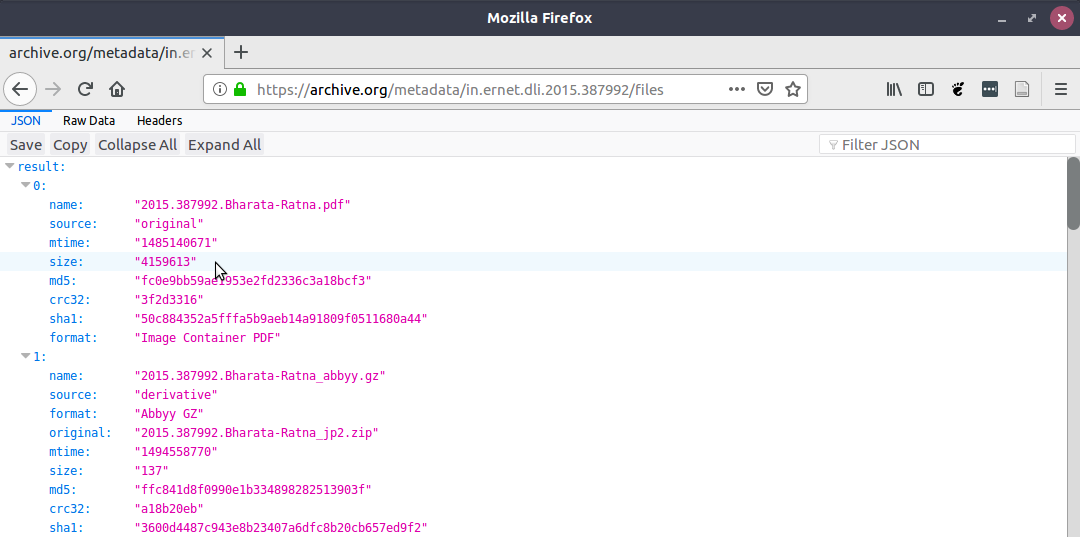

In [14]:
Image(filename='pics/file size of internet archive item.png')

In [15]:
sum('Success' in s for s in dupcompare)

3403

In [16]:
sum('Fail'  in s for s in dupcompare )

224

## Explore content 
So 3393 rows have exactly same items, 221 rows have some different items. Let's investigate second row, which is a failure.

Let's see the items on the first line  which have exactly same file size.
## Duplicates with same file size

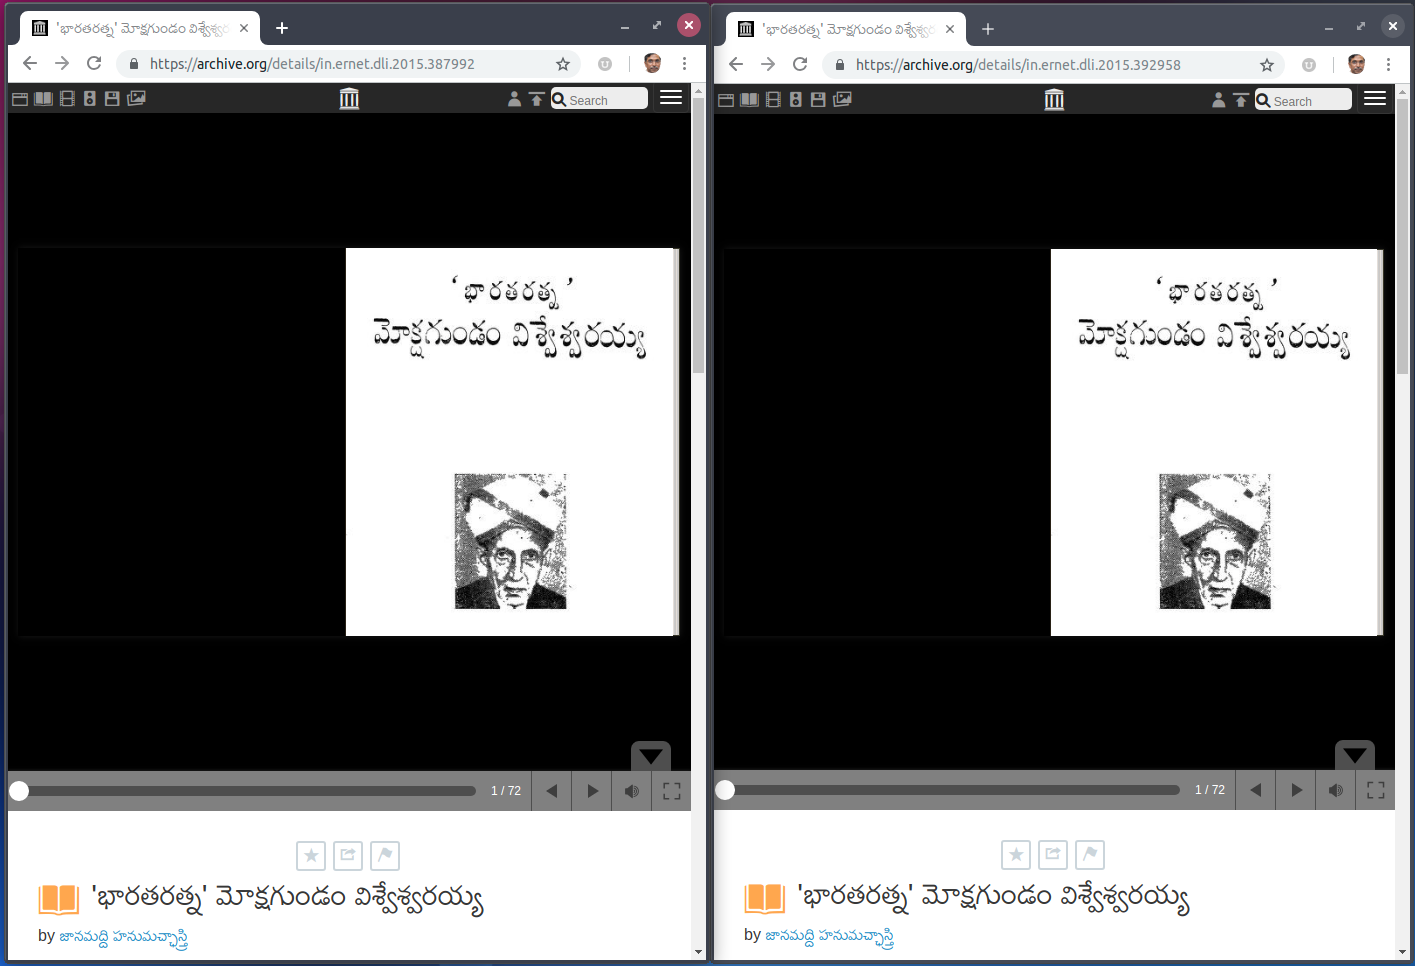

In [17]:
Image(filename="pics/Exact Duplicates tophalf.png")

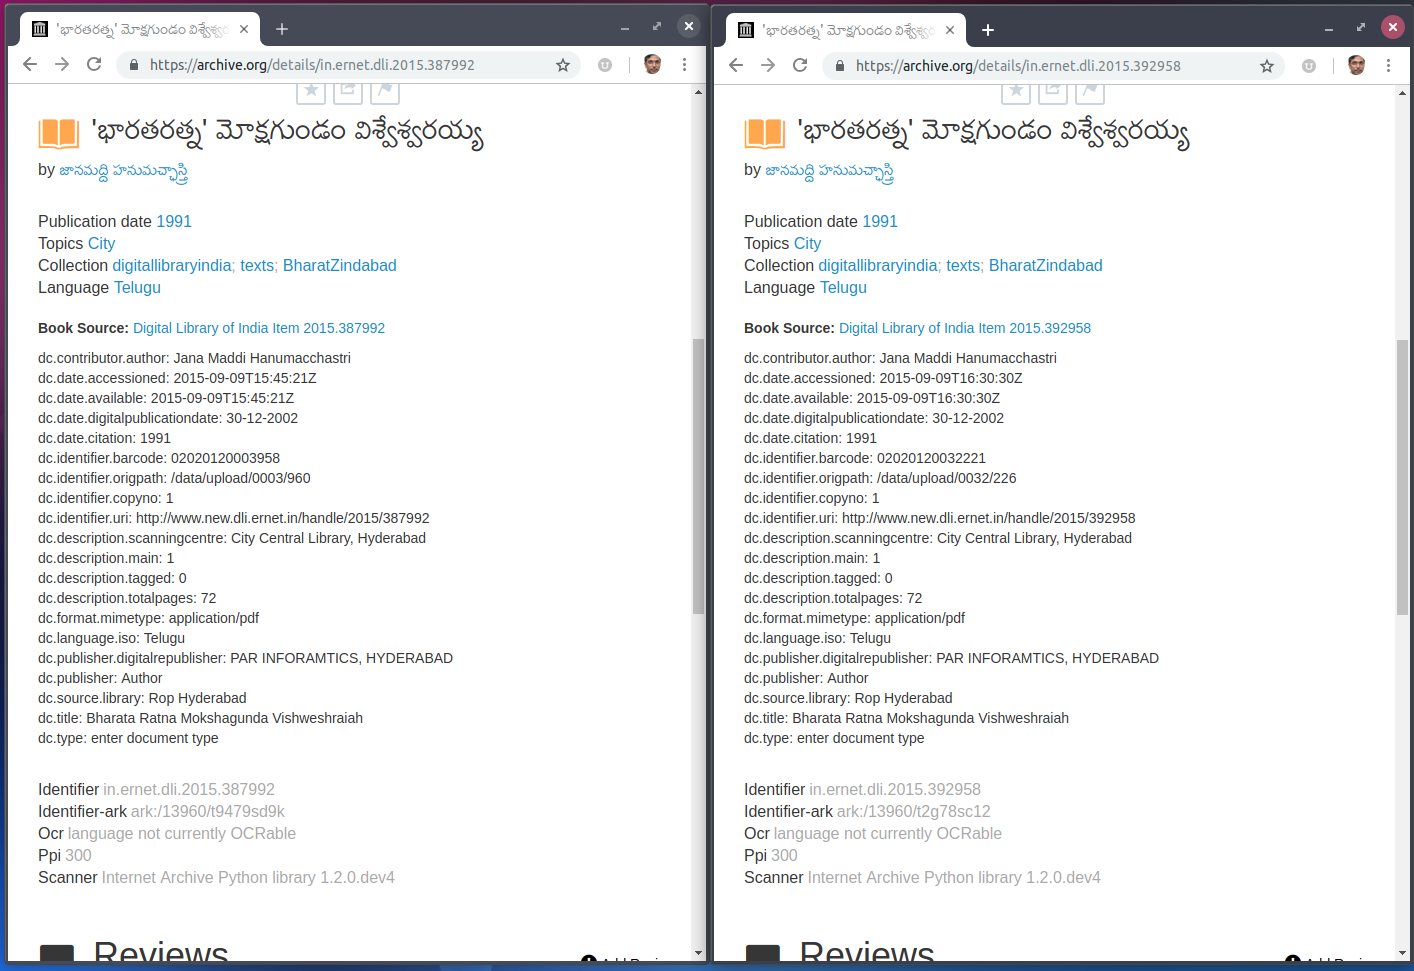

In [18]:
Image(filename="pics/Exact Duplicates bottomhalf.png")

From the above first page image and meta details, we can see that the same scan center produced these items, the book was sourced from the same library/institution(Registrar of publications(Rop), Hyd) and the items were web enabled in a time span of 45 minutes. This is an example of many such duplications which DLI process failed to prevent.

Now Let us look at an example of items with same title,author,pubdate,pages information, but with different file sizes

## Duplicates with different file sizes -Example 1

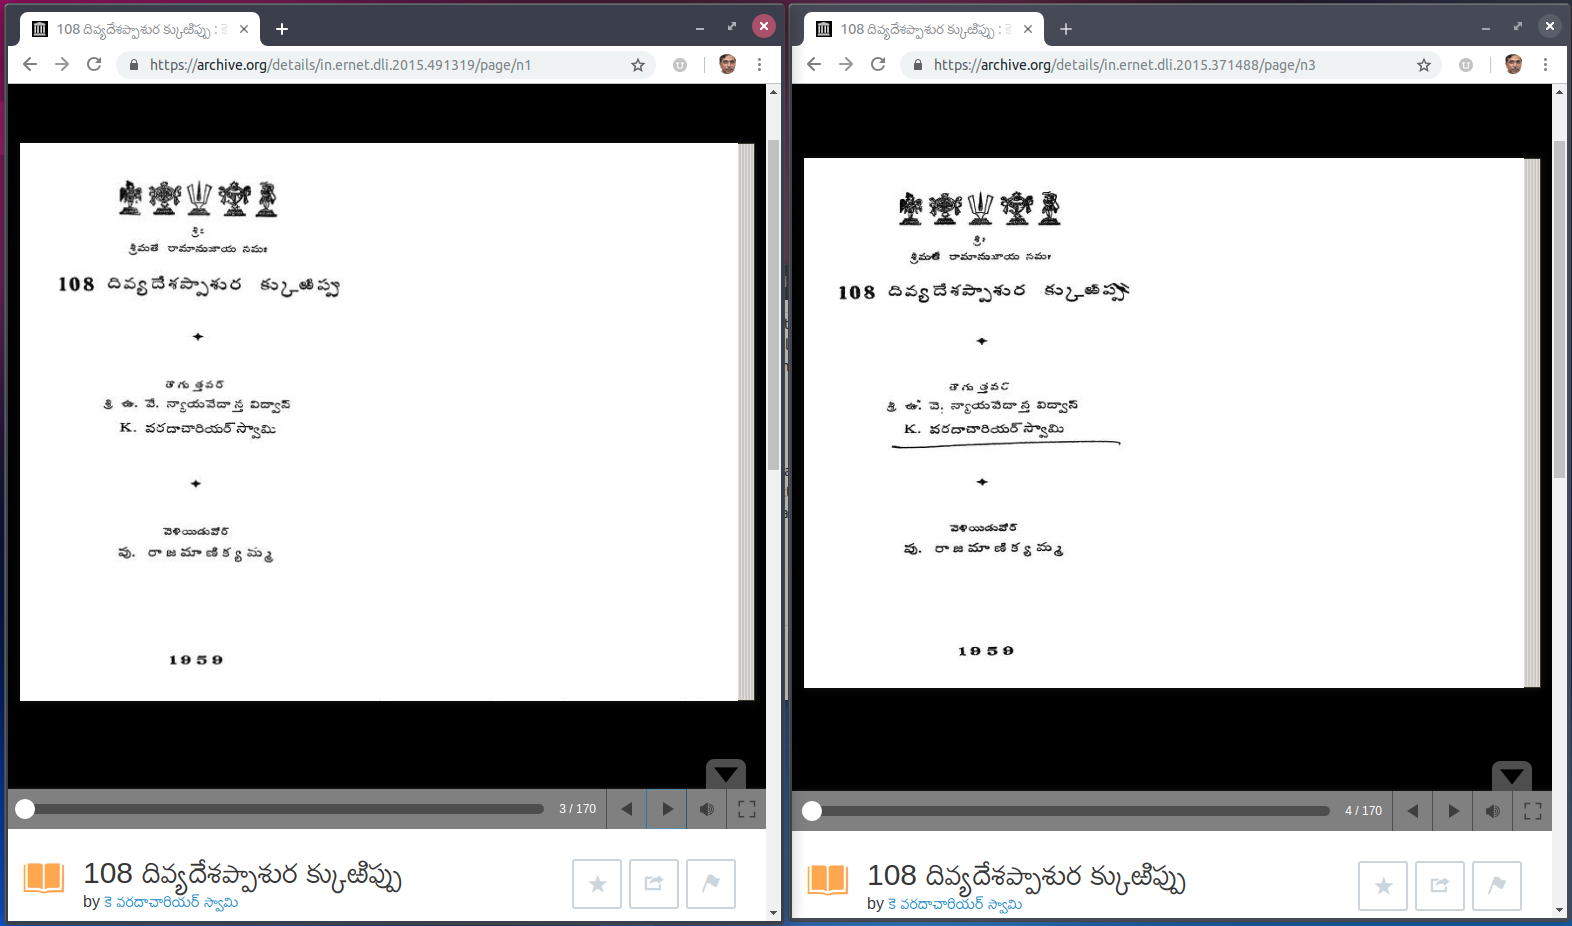

In [19]:

Image(filename="pics/DupSet 108 divya1.png") 

Note the folio number is different for the same content. There is some handwritten line on the second item.

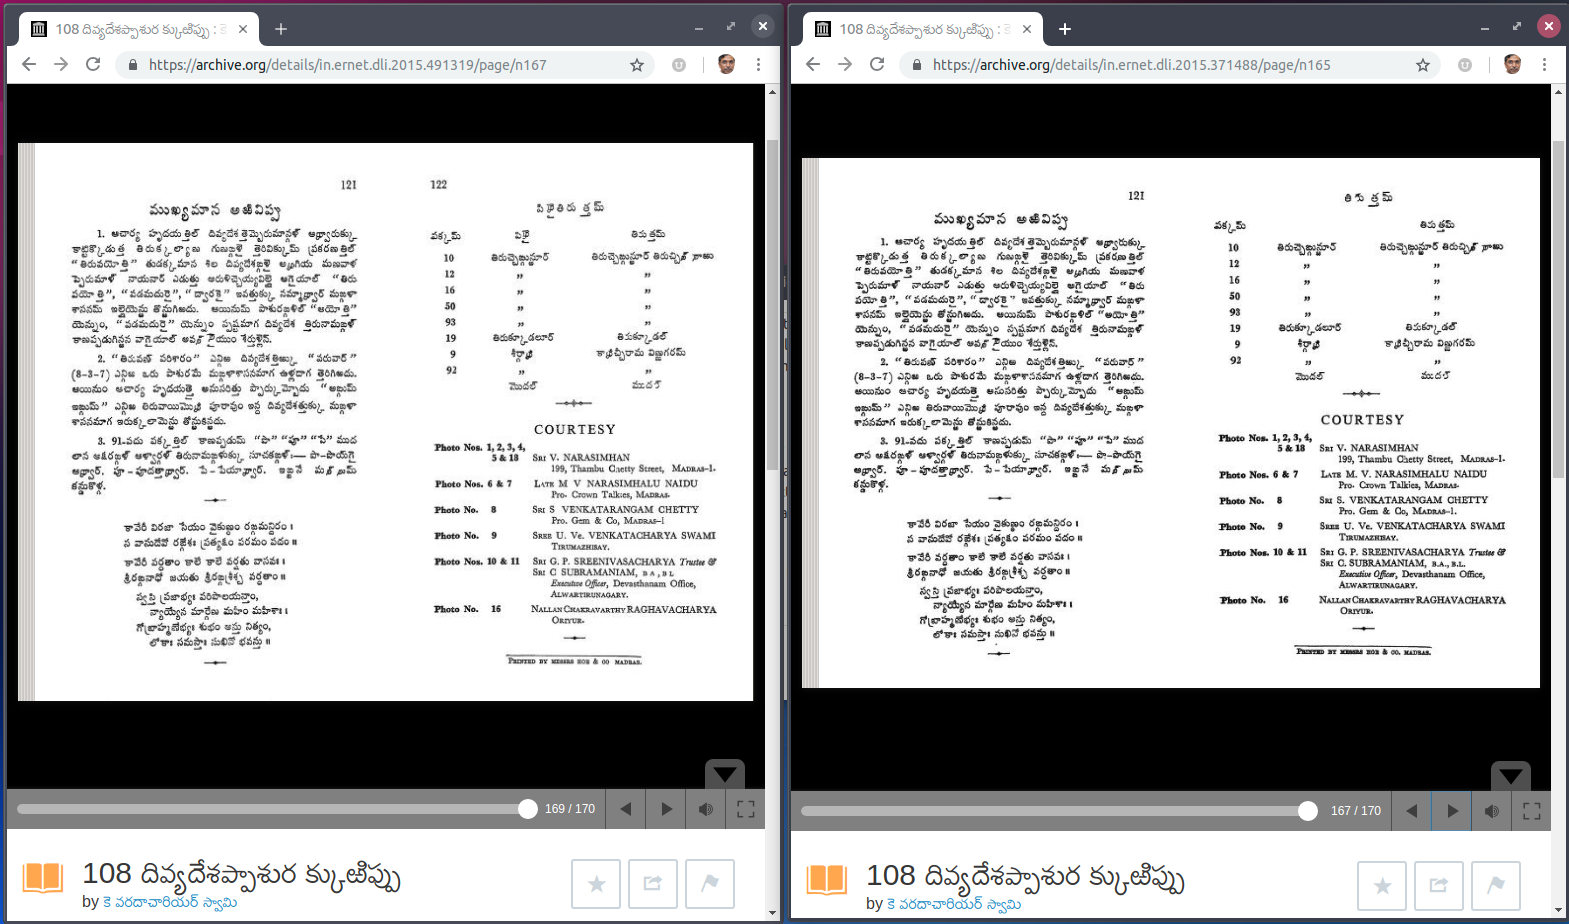

In [20]:
Image(filename="pics/DupSet 108 divya2.png")

The final pages are also present though at slightly different folios. The total of pages are same.

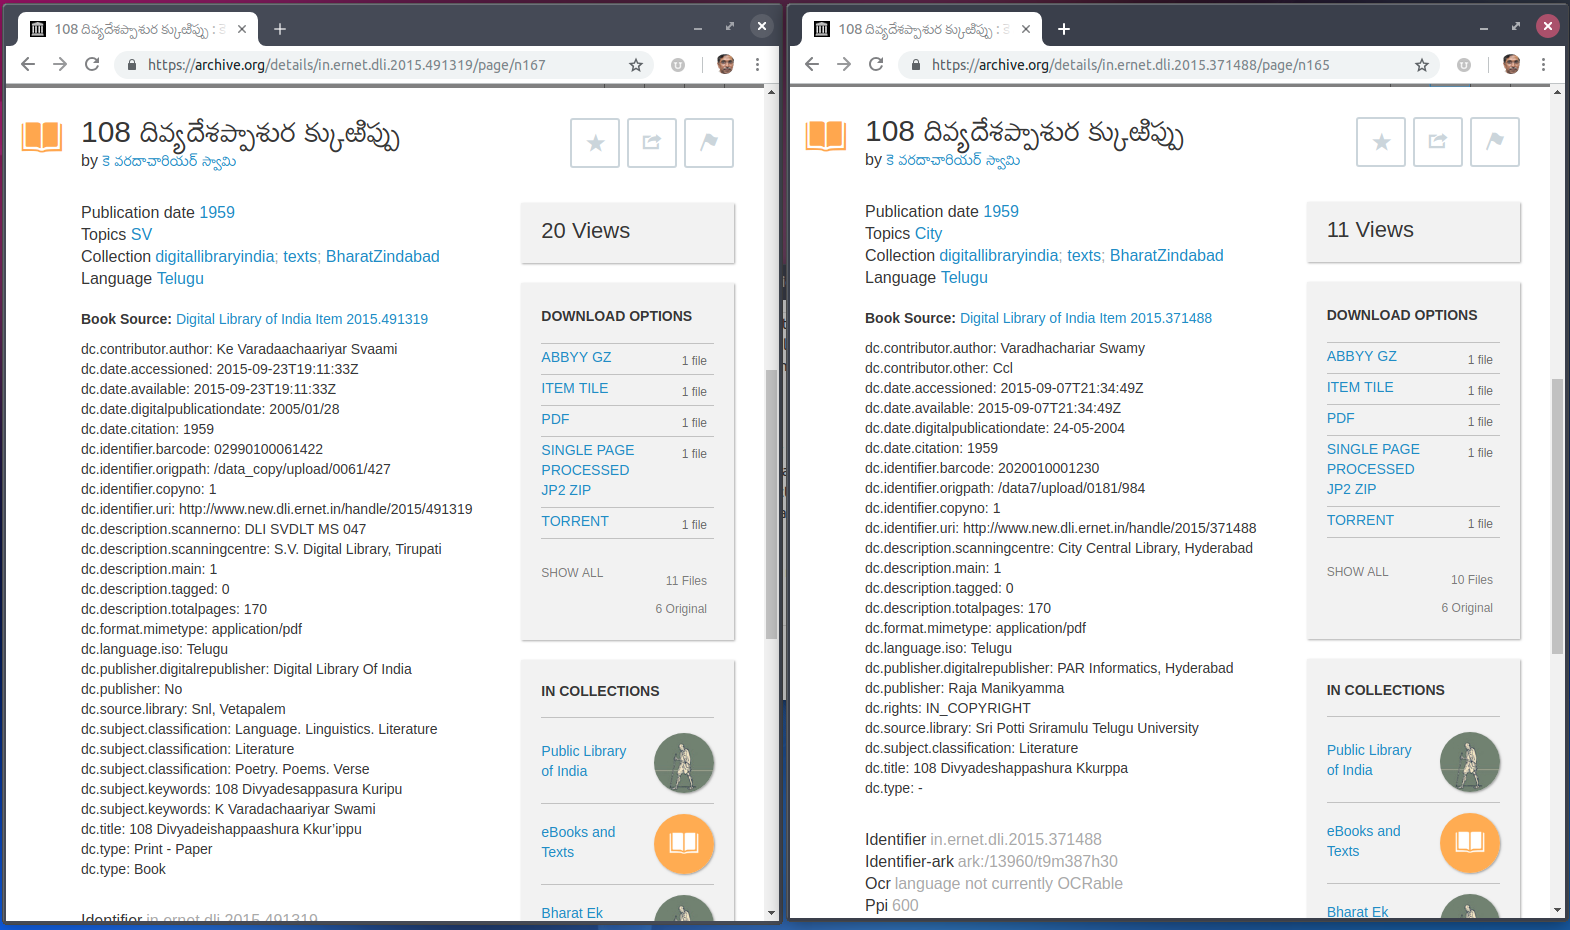

In [21]:
Image(filename="pics/DupSet 108 divya3.png")

Looking at the meta information, we can see that the source library  and scanning centres are different accounting for slight differences observed. Actually this sort of duplication was also sought to be avoided by DLI, which apparently failed for several cases. 

## Duplicates with different file sizes -Example 2
Lets look at another example.

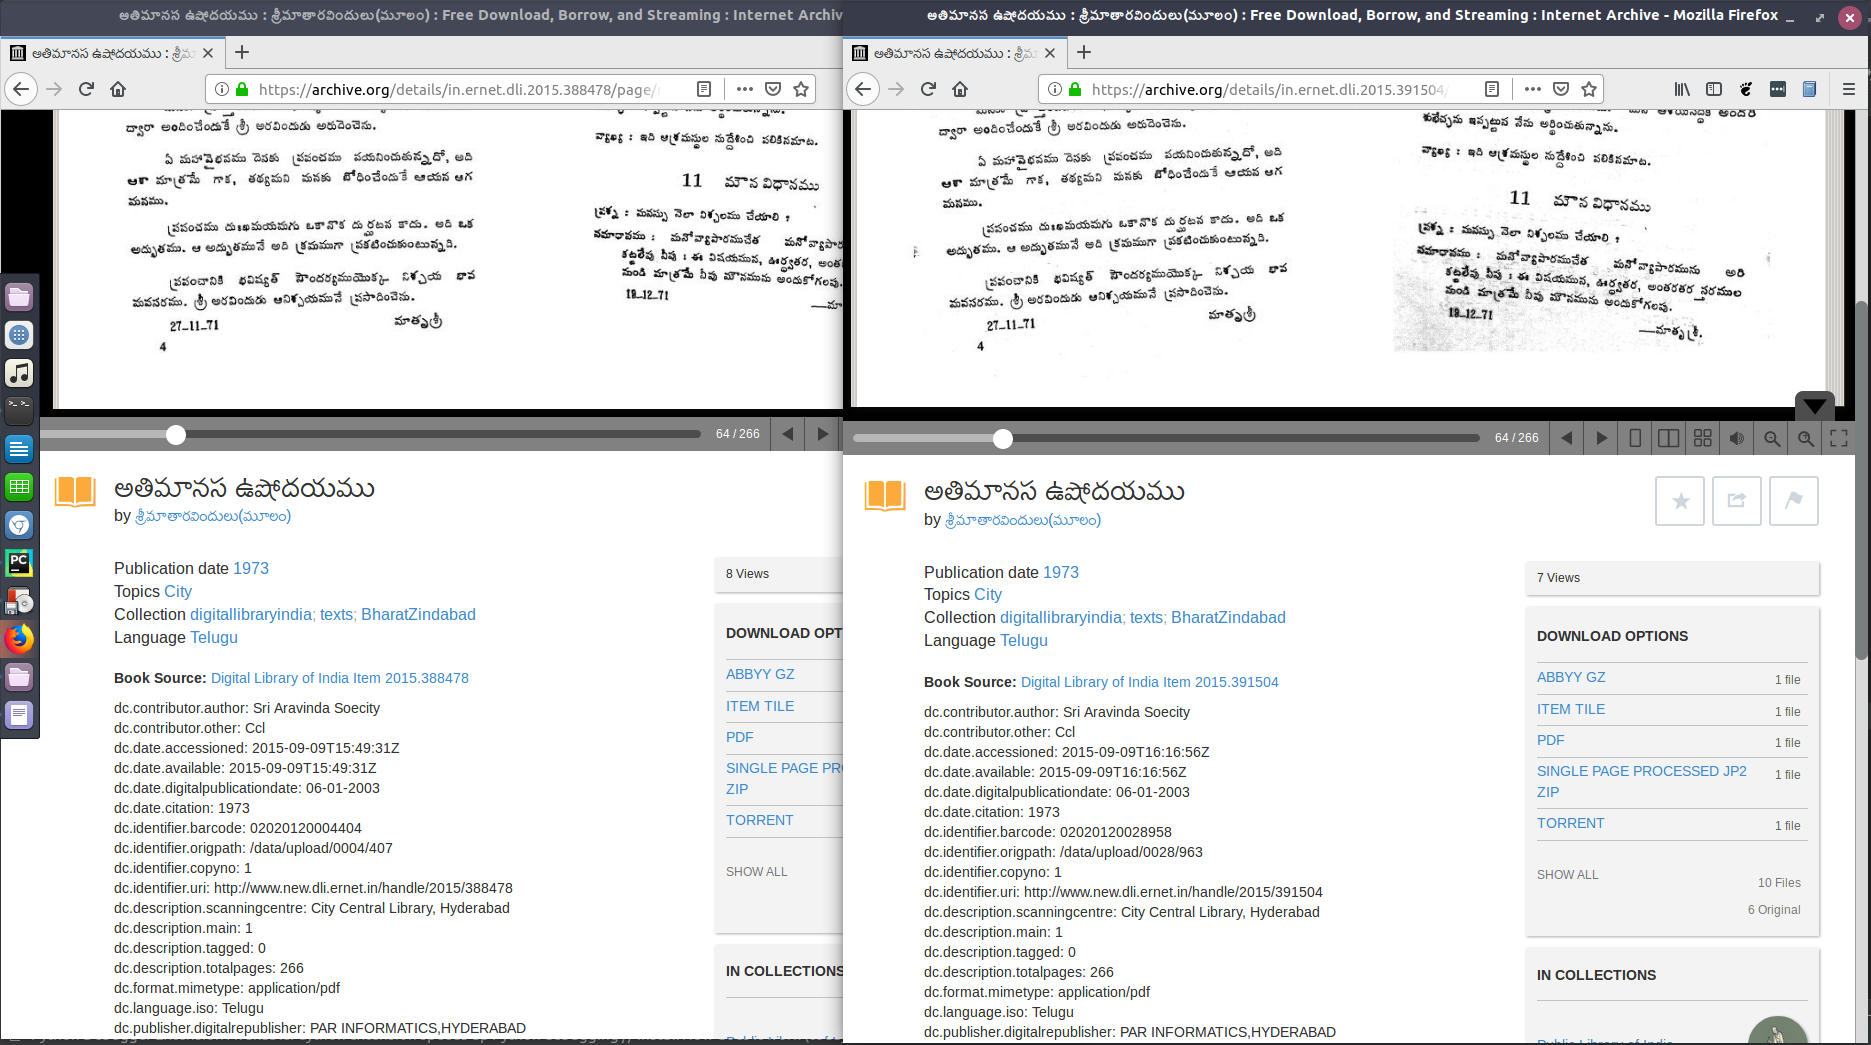

In [22]:
Image(filename="pics/DuplicatesDueToImageProcessing.png")

In the above pic, you can see that the source library of the book, scanning center is same, , but the operator changed some image processing parameters and created a duplicate item. This was also supposed to be avoided by DLI, but apparently failed in some cases.


## Duplicates with different file sizes -Other observations

We found cases where one item has additional scan page, without change in total number of pages, leading to differen file size.

We also found that the number of pages is not exactly computer generated as it varied in some cases.

As the duplicates as a percentage of the collection is still large, Let us decide on the duplicates to be deleted, based on the original file size criteria.

For this the duplicates set is further analysed to identify duplicates subsets. For example, if a set has 6 ids with two different file sizes, it can be split into two subsets with uniform size. If a set has 2 ids with different sizes, they will be split into two 1 element sets, meaning we will consider them as different.


In [23]:
# Read from the duplicates size comparison output, when there is success, write the ids, when there is a fail,
# find subsets which have samesize, write their ids, and also write uniques if exist() using csv module
def splitdup_size(inpfile, outfile,numlines):
    import pandas as pd
    import numpy as np
    import csv

    line = 0
    fi = open(inpfile, 'r')
    csvfile = open(outfile, 'w', newline="")
    writer = csv.writer(csvfile, delimiter=",")
    for row in fi.readlines():
        line += 1
        if row.find("Fail") != -1:
            row = row.replace(",Fail\n", "")
            info = row.split(",")
            ids = []
            sizes = []
            for i, j in zip(info[0::2], info[1::2]):
                ids.append(i)
                sizes.append(j)
            isf = pd.DataFrame({'id': pd.Series(ids), 'size': sizes})
            isfg = isf.groupby(['size'], sort=False)

            for name, group in isfg:
                duplist = group['id'].tolist()
                writer.writerow(duplist)
        else:
            row = row.replace(",Success\n", "")
            info = row.split(",")
            ids = []
            sizes = []
            for i, j in zip(info[0::2], info[1::2]):
                ids.append(i)
                sizes.append(j)
            isf = pd.DataFrame({'id': pd.Series(ids), 'size': sizes})
            isfg = isf.groupby(['size'], sort=False)
            for name, group in isfg:
                duplist = group['id'].tolist()
                writer.writerow(duplist)
        if (numlines != 0) and (line > numlines):
            break

    csvfile.close()

splitdup_size('data/flagdupsetresult2trans.csv','data/flagduprevised.csv',0)

In [24]:
fi=open("data/flagduprevised.csv",'r')
lines=[]
for row in fi.readlines():
    lines.append(row)

len(lines)

3858

Now we have 3858 lines. Let's count number of lines with one id (the string length only one id with newline equals 25)

In [25]:
newl=[i for i in lines if len(i)==25]
len(newl)

302

In [26]:
lines[0:5]


['in.ernet.dli.2015.387992,in.ernet.dli.2015.392958\n',
 'in.ernet.dli.2015.371488\n',
 'in.ernet.dli.2015.491319\n',
 'in.ernet.dli.2015.388747,in.ernet.dli.2015.390039,in.ernet.dli.2015.390104,in.ernet.dli.2015.393095\n',
 'in.ernet.dli.2015.388423,in.ernet.dli.2015.388530,in.ernet.dli.2015.389870,in.ernet.dli.2015.392879\n']

You can see that the second row from the earlier set is now split into two, as the ids have different file sizes.

Below we present shell script generation for adding curation notes and delete commands.

In [27]:
ffo=open("data/dup flag 20181126.sh","w")
fdo=open("data/dup delete 20181126.sh","w")
fi=open("data/flagduprevised.csv",'r')
line=0
import time
for row in fi.readlines():
    line+=1
    row=row.strip("\n")
    ids=row.split(",")
    for i in range(0,len(ids)):
        if i==0:
            if len(ids)>1:
                curation_notes=row.replace(ids[0]+",","")
                #write curation command
                cutime=time.strftime("%Y%m%d%H%M%S")
                cucommand=("ia metadata %s  --modify=\"curation:[curator]arjunaraoc@gmail.com[/curator]"
                    "[date]%s[/date]"
                    "[comment]Exact duplicates (Archive identifiers) of this item, which are likely to be "
                    "hidden or deleted: %s [/comment]\"\n" % (ids[0],cutime, curation_notes))  
                ffo.write(cucommand)
            
        else:
            fdo.write("ia delete "+ids[i]+" -H x-archive-keep-old-version:0\n")
    

ffo.close()
fdo.close()

Using the above, we generate curation information for 3556 (3858-302) ids and deletion information for 5244 items 
(total ids(9102) -curated ids(3556) -unique items(302))
With the exact duplicates removed, we will have a better Telugu collection, which will be user friendly and will require about 23% less effort for any improvement.

Samples from the shell scripts generated above is given below. Note Curation information is available through searching and not shown on the item page.


**Sample commands for adding curation**

ia metadata in.ernet.dli.2015.387992  --modify="curation:[curator]arjunaraoc@gmail.com[/curator][date]20181126164406[/date][comment]Exact duplicates (Archive identifiers) of this item, which are likely to be hidden or deleted: in.ernet.dli.2015.392958 [/comment]"


**Sample commands for deletion with no backup**

ia delete in.ernet.dli.2015.392958 -H x-archive-keep-old-version:0

## Conclusion

The study has helped us understand the quality problems in Digital Library of India  Telugu Collection and identify the best approach to find duplicates. As most of the metadata is unreliable for indic languages, the best approach is to rely on file size of the original uploaded to internet archive to determine exact duplicates. After that, a  cursory check of the title, author,publication date and number of pages, can give almost full confidence to identify and weed out duplicates. This will help reduce the further maintainance of the collection and make the colletion more user friendly, with more meaningful search recommendations.